<a href="https://colab.research.google.com/github/Zshoham/YHB/blob/main/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [ ]:
def reshape_data(data):
  images = list()
  for d in data:
      image = np.zeros((32,32,3), dtype=np.uint8)
      image[...,0] = np.reshape(d[:1024], (32,32)) # Red channel
      image[...,1] = np.reshape(d[1024:2048], (32,32)) # Green channel
      image[...,2] = np.reshape(d[2048:], (32,32)) # Blue channel
      images.append(image)
  return np.array(images)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import requests
import tarfile
import os

dev = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(dev[0], True)
print(tf.test.gpu_device_name())

if not os.path.isdir('cifar-100-python'):
  data = requests.get("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")
  with open("cifar100.tar.gz", 'wb') as f:
      f.write(data.content) 

  tar = tarfile.open("cifar100.tar.gz", "r:gz")
  tar.extractall()
  tar.close()

# loading the raw cifar100 data
cifar_train = unpickle("cifar-100-python/train")
cifar_test = unpickle("cifar-100-python/test")

# extracting the training data.
train_data = reshape_data(cifar_train[b'data'])
train_labels = np.array(cifar_train[b'coarse_labels'])
train_fine_labels = np.array(cifar_train[b'fine_labels'])

# extracting the testing data
test_data = reshape_data(cifar_test[b'data'])
test_labels = np.array(cifar_test[b'coarse_labels'])
test_fine_labels = np.array(cifar_test[b'fine_labels'])

# extracting the kabek names
meta = unpickle("cifar-100-python/meta")
label_names = meta[b'coarse_label_names']
fine_label_names = meta[b'fine_label_names']

label_names = np.array(list(map(lambda bstr: bstr.decode("utf-8"), label_names)))
fine_label_names = np.array(list(map(lambda bstr: bstr.decode("utf-8"), fine_label_names)))

/device:GPU:0


# Data Exploration

In [ ]:
import math
# plot a group of images in a grid, note: len(images) must be a square number
def plot_images(images, labels=None, fig_size=(10,10)):
  size = int(math.sqrt(len(images)))
  fig, aux = plt.subplots(size, size, figsize=fig_size)
  aux = aux.flatten()
  for i in range(0,aux.size):
    aux[i].imshow(images[i])
    if labels is not None:
      aux[i].title.set_text(labels[i])

In [ ]:
def get_label_name(label_id):
  return fine_label_names[label_id]

def get_label_id(label_name):
  return np.where(fine_label_names == label_name)[0][0]

The dataset is split into two sets, training data and test data. All images are 32x32 with RGB color channals. There are 2 types of labels, "high level" categories of which there are 20, and "low level" categories of which there are 100. Each of the 100 low level categories belongs to a high level category. We start by observing the number of samples in each set, and the distribution of labels.

number of high level labels: 20
number of low level labels: 100
number of training imeges: 50000
number of testing imeges: 10000
image shape: (32, 32, 3)


<BarContainer object of 100 artists>

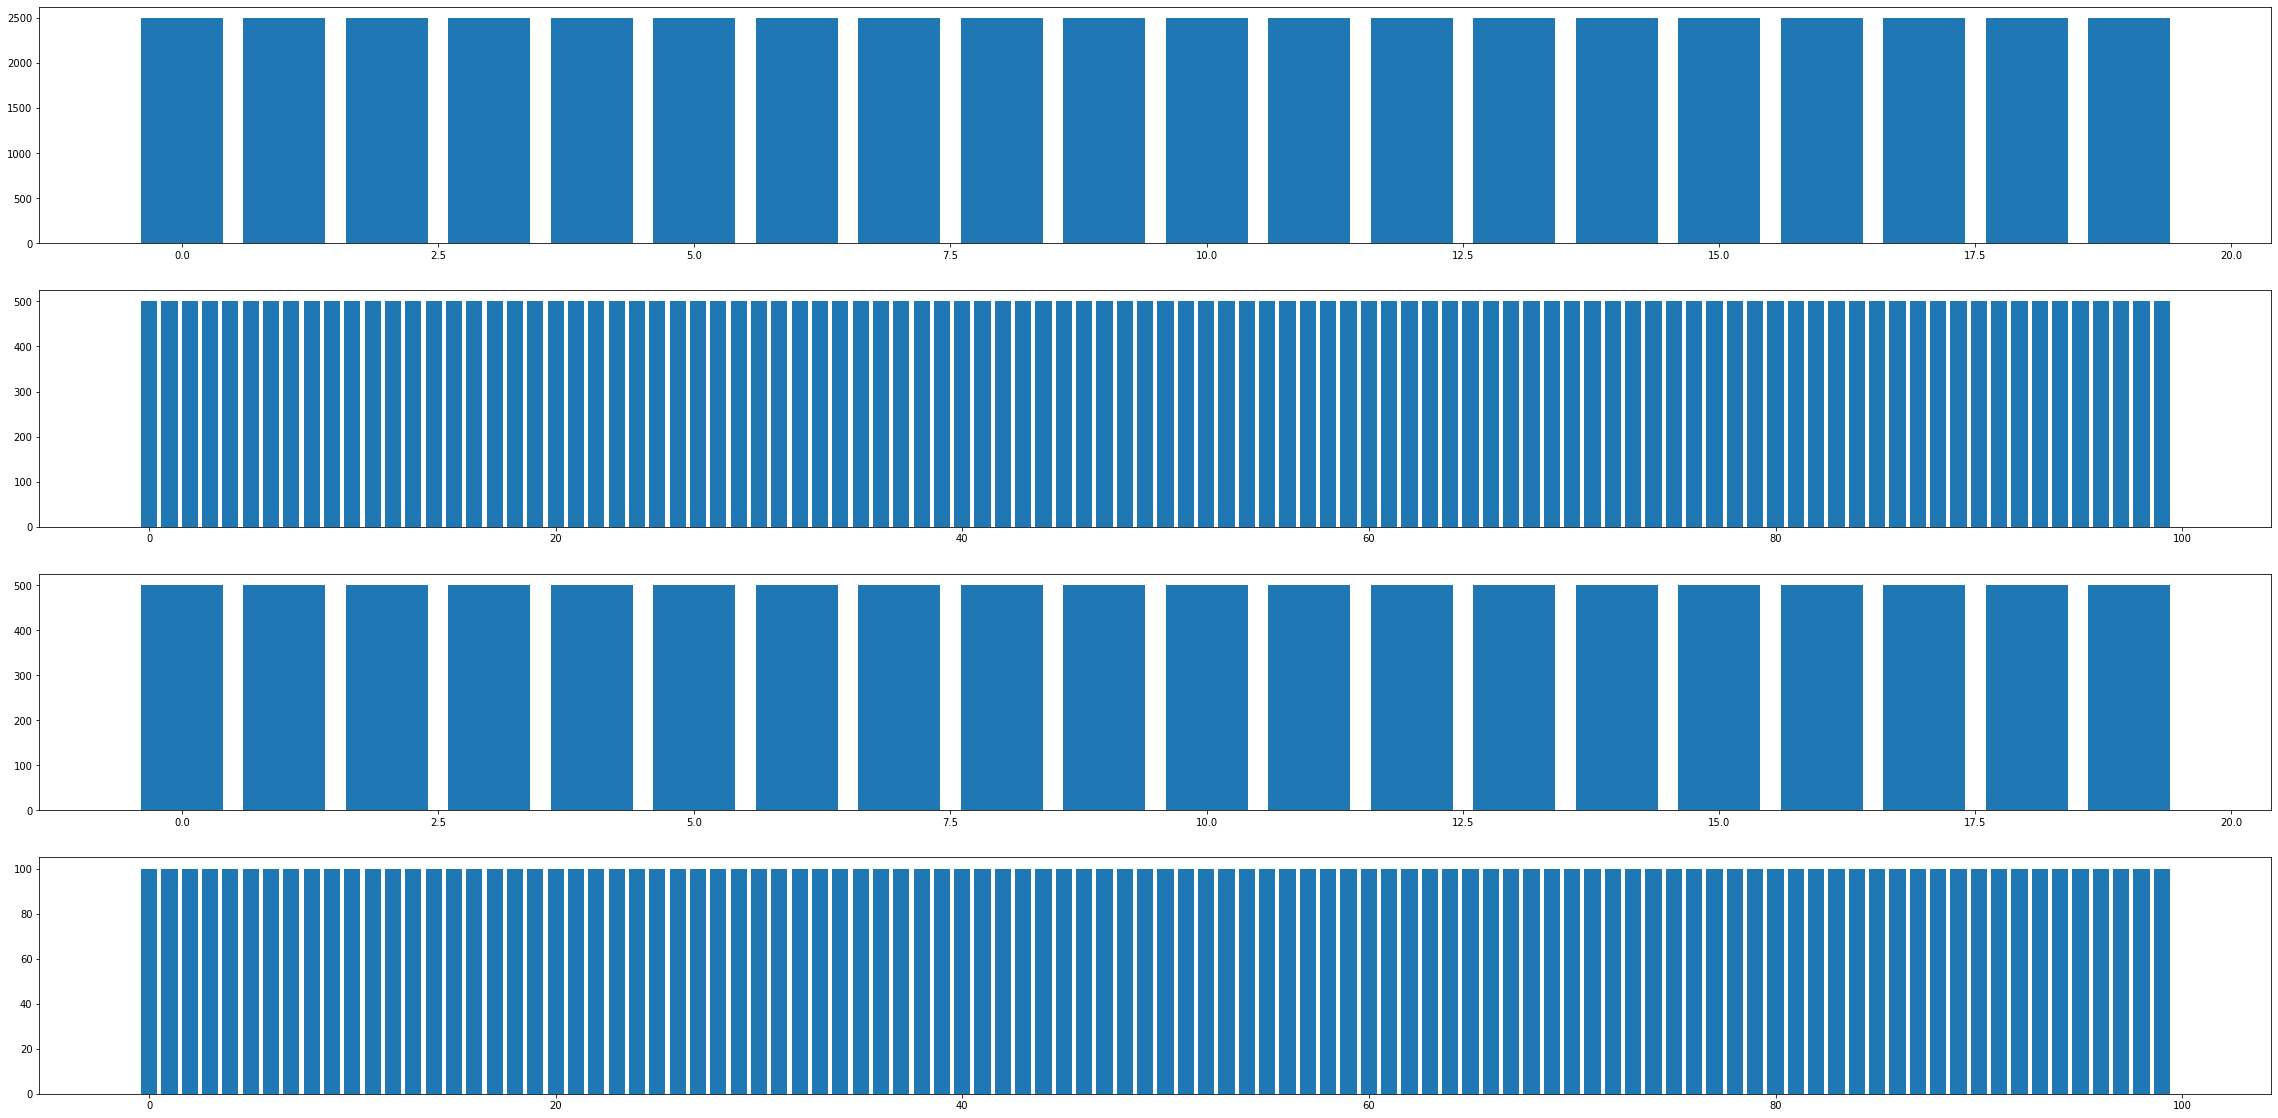

In [ ]:
print("number of high level labels: " + str(label_names.size))
print("number of low level labels: " + str(fine_label_names.size))

print("number of training imeges: " + str(len(train_data)))
print("number of testing imeges: " + str(len(test_data)))

print("image shape: " + str(train_data[0].shape))

train_lbl, train_lbl_counts = np.unique(train_labels, return_counts=True)
train_fine_lbl, train_fine_lbl_counts = np.unique(train_fine_labels, return_counts=True)

test_lbl, test_lbl_counts = np.unique(test_labels, return_counts=True)
test_fine_lbl, test_fine_lbl_counts = np.unique(test_fine_labels, return_counts=True)

fig, aux = plt.subplots(4, figsize=(40,20))
aux[0].bar(train_lbl, train_lbl_counts, label="training high level label distribution")
aux[1].bar(train_fine_lbl, train_fine_lbl_counts, label="training low level label distribution")
aux[2].bar(test_lbl, test_lbl_counts, label="testing high level label distribution")
aux[3].bar(test_fine_lbl, test_fine_lbl_counts, label="testing low level label distribution")


As we can see from the plots above, the label distribution in the data is perfectly uniform, each high level label having 2500 training examples and 500 testing examples, while each low level label has 500 training examples and 100 testing examples.

Next Lets take a look at the labels and images themselves. First we show an example of 25 images with their labels. We can immediatly see two things:
 * The big veriaty of images and labels available
 * How liitle image data available for each image, many images are bearly recognizable even to humans.

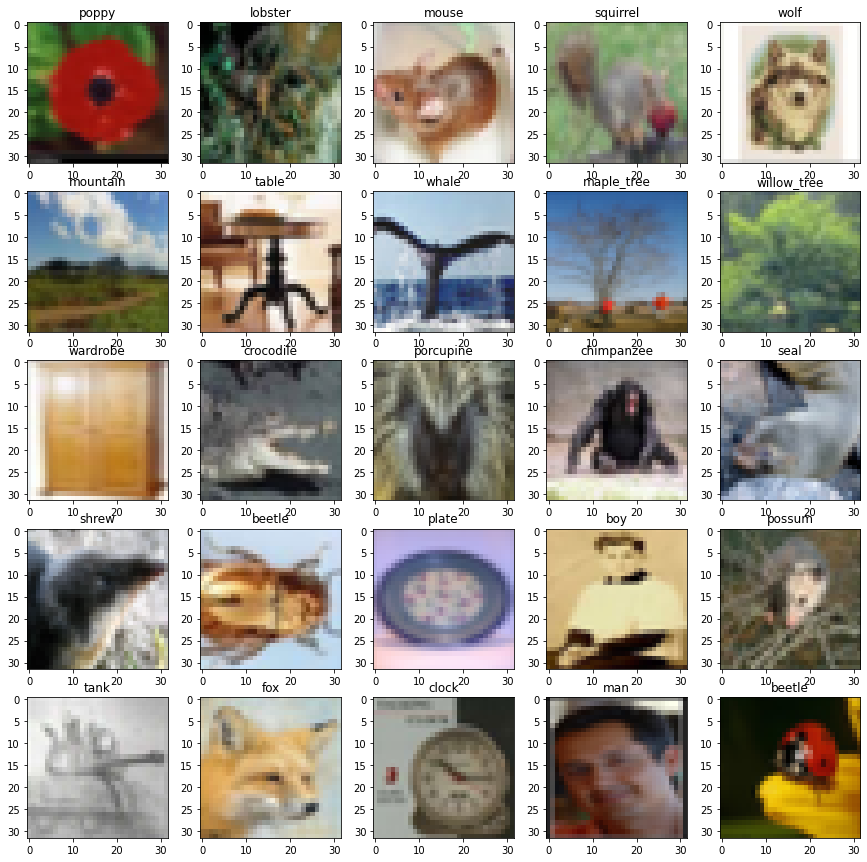

In [ ]:
example_indecies = np.random.choice(np.arange(len(train_labels)), 25, replace=False)
plot_images(train_data[example_indecies], fine_label_names[train_fine_labels[example_indecies]], (15,15))

Next lets take a look at the labels we are going to use (we'll only use the low level labels for our models)

In [ ]:
print(fine_label_names)

['apple' 'aquarium_fish' 'baby' 'bear' 'beaver' 'bed' 'bee' 'beetle'
 'bicycle' 'bottle' 'bowl' 'boy' 'bridge' 'bus' 'butterfly' 'camel' 'can'
 'castle' 'caterpillar' 'cattle' 'chair' 'chimpanzee' 'clock' 'cloud'
 'cockroach' 'couch' 'crab' 'crocodile' 'cup' 'dinosaur' 'dolphin'
 'elephant' 'flatfish' 'forest' 'fox' 'girl' 'hamster' 'house' 'kangaroo'
 'keyboard' 'lamp' 'lawn_mower' 'leopard' 'lion' 'lizard' 'lobster' 'man'
 'maple_tree' 'motorcycle' 'mountain' 'mouse' 'mushroom' 'oak_tree'
 'orange' 'orchid' 'otter' 'palm_tree' 'pear' 'pickup_truck' 'pine_tree'
 'plain' 'plate' 'poppy' 'porcupine' 'possum' 'rabbit' 'raccoon' 'ray'
 'road' 'rocket' 'rose' 'sea' 'seal' 'shark' 'shrew' 'skunk' 'skyscraper'
 'snail' 'snake' 'spider' 'squirrel' 'streetcar' 'sunflower'
 'sweet_pepper' 'table' 'tank' 'telephone' 'television' 'tiger' 'tractor'
 'train' 'trout' 'tulip' 'turtle' 'wardrobe' 'whale' 'willow_tree' 'wolf'
 'woman' 'worm']


obviously some labels are more similar then others, lets take a look at some examples.

In [ ]:
def get_label_examples(data, label, size=10):
  lbl_indx = np.arange(len(train_fine_labels))
  lbl_filter = train_fine_labels == get_label_id(label)
  indecies = np.random.choice(lbl_indx[lbl_filter], size, replace=False)
  return data[indecies]

Here we see some images of apples and lions ( two apples above and two lions below), though some images are a little hard to identify, the two classes are easily seprebale.

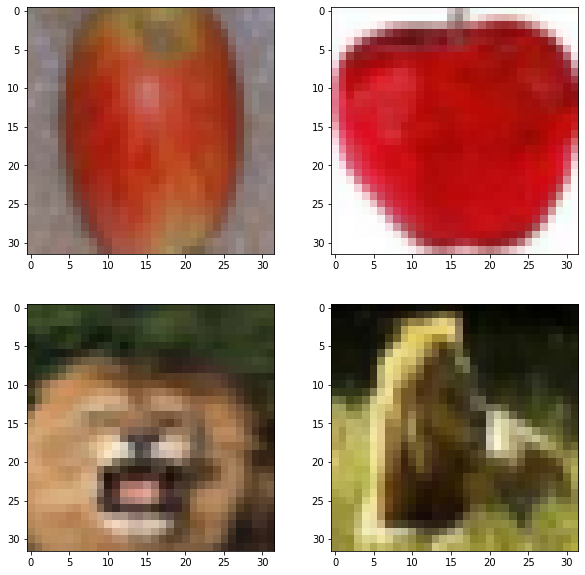

In [ ]:
apple_examples = get_label_examples(train_data, 'apple', size=2)
bee_examples = get_label_examples(train_data, 'lion', size=2)
examples = np.concatenate((apple_examples, bee_examples))
plot_images(examples)

Here we see some images of willow trees and oak trees ( two willow trees above and two oak trees below), Those are much harder to seperate, expecially with the very low resultion of the images

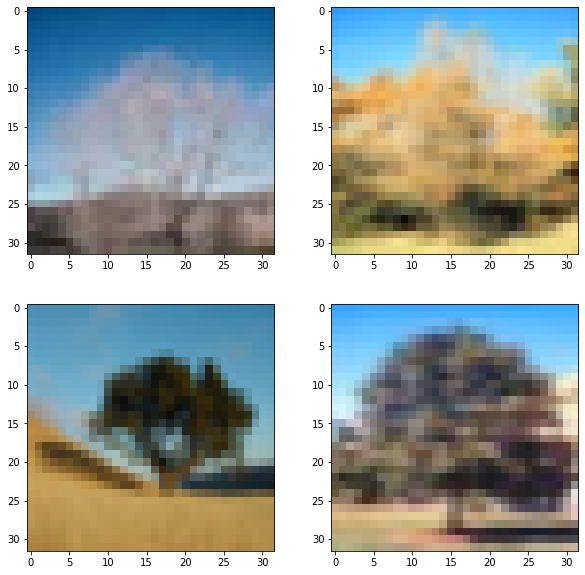

In [ ]:
apple_examples = get_label_examples(train_data, 'willow_tree', size=2)
bee_examples = get_label_examples(train_data, 'oak_tree', size=2)
examples = np.concatenate((apple_examples, bee_examples))
plot_images(examples)

After seeing the data, we can start preparing it for use in our models. sience we are going to be using neural networks, the data should be in the (0-1) range, so we'll start by normalizing the data by deviding all the integer values by 255. We plot 25 random images again to make sure that the images are preserved after the normalization.

72337

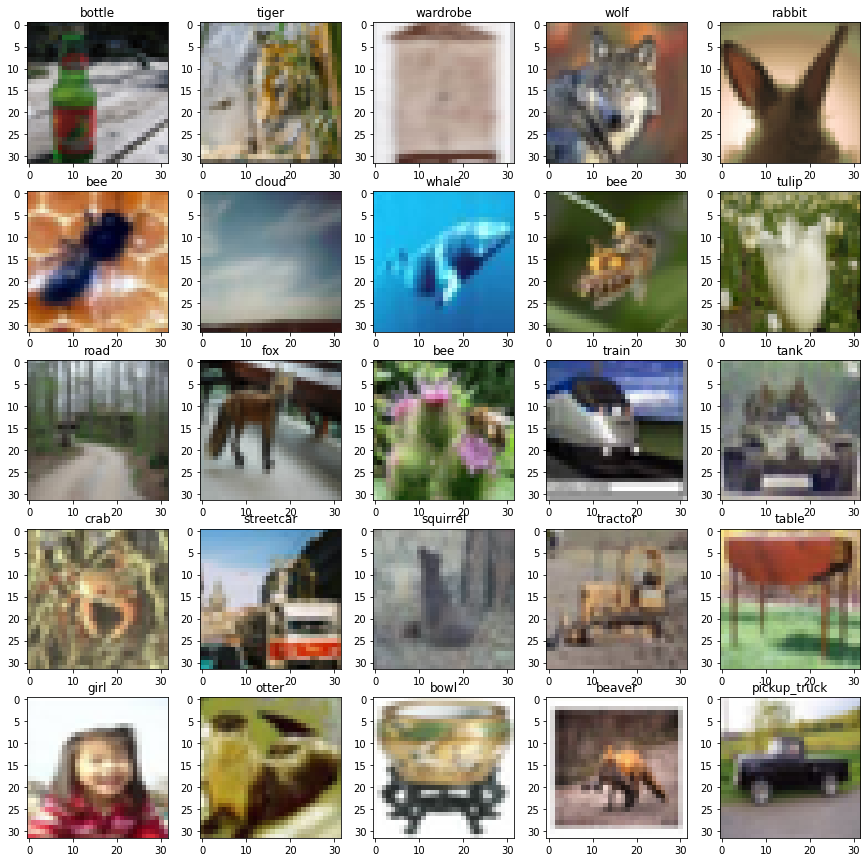

In [ ]:
import gc

train_data = train_data.astype(np.float32) / 255
test_data = test_data.astype(np.float32) / 255
example_indecies = np.random.choice(np.arange(len(train_labels)), 25, replace=False)
plot_images(train_data[example_indecies], fine_label_names[train_fine_labels[example_indecies]], (15,15))

gc.collect()

Next is data augmentation, We try three different modes of augmentation:
* in place - meaning we augment some of the images in the training data to increase variance.
* addition - we increase the size of the training data by creating variations of the images we have.
* non - we try to use the original data with no augmentation.

The kinds of augmentations we use are as follows:

* Crop - small crops preserving image size, should not affect the image label
* GaussianNoise - adding small noise to the image will also not affect it but will increase the variance of the data.
* Flip - we add the flipped images to the training data, there are no labels that can be affected by flipping and such an augmantation could generates more general knowladge of the label.
* Transform - we add the transformed image to the training data, sometimes moving the image a few pixels along the y axis, and sometimes moving it along the x axis.
* Brightness - we change the image brightness a little adding the changed image to the training data, this should not change any labels as the brighness change is not big enough to obscure the data.
* Rotate - we add the rotated image to the training data, the rotation is up to 45 degrees, and thus is not enough to change the image label.

After applying the addition augmentation we shuffle the training data in order to no have a clear seperation between the orignial and augmented images.

In [ ]:
import imgaug.augmenters as iaa
import imgaug as ia

aug_inplace = iaa.Sequential([
    iaa.Sometimes(0.2, iaa.Crop(px=(1, 4), keep_size=True)),
    iaa.AdditiveGaussianNoise()
])

def aug_add(data, labels, shuffle=True):

  flip = iaa.Fliplr(1.0)

  trans = iaa.OneOf([
      iaa.Affine(translate_percent={"x": (-0.2, 0.2)}, mode="edge"),
      iaa.Affine(translate_percent={"y": (-0.2, 0.2)}, mode="edge")
  ])

  bor = iaa.OneOf([
      iaa.Add((-0.2, 0.2)),
      iaa.Affine(rotate=(-45, 45), mode="edge")
  ])

  cp_1 = np.copy(data)
  cp_2 = np.copy(data)
  cp_3 = np.copy(data)

  if shuffle:
    aug_data = np.concatenate((data, flip(images=cp_1), trans(images=cp_2), bor(images=cp_3)))
    aug_labels = np.concatenate((labels, labels, labels, labels))
    # we use the same seed before the suffles to achive the same order 
    # in the data and the labels.
    np.random.seed(400)
    np.random.shuffle(aug_data)
    np.random.seed(400)
    np.random.shuffle(aug_labels)
  else:
    aug_data = np.stack((data, flip(images=cp_1), trans(images=cp_2), bor(images=cp_3)))
    aug_labels = np.stack((labels, labels, labels, labels))

  return aug_data, aug_labels


# Simple Model



We use wandb.com to log our model progression, visit https://wandb.ai/zshoham/dl_assignment1 for full model report.

In [ ]:
!pip install wandb -qqq
import wandb
!wandb login

wandb: Currently logged in as: zshoham (use `wandb login --relogin` to force relogin)


In [1]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback
import gc

def log_metrics(model, scores, data, probabilaties, labels):
    for i in range(0, len(scores)):
      print(f'Score : test_{model.metrics_names[i]} of {scores[i]}')
      wandb.log({f'test_{model.metrics_names[i]}': scores[i]}, commit=False)

    print(probabilaties.shape)
    prob_max = np.amax(probabilaties, axis=1)
    predictions = np.argmax(probabilaties, axis=1)
    print(predictions.shape)
    print(labels.shape)
    pr = precision_score(labels, predictions , average="macro")
    rc = recall_score(labels, predictions , average="macro")
    f1 = f1_score(labels, predictions , average="macro")
    wandb.log({"precision": pr, "recall": rc, "f1": f1}, commit=False)

    certain = np.argmax(prob_max, axis=0)
    uncertain = np.argmin(prob_max, axis=0)

    # we apply f(x)=-x to all the correct predictions, so that we will
    # get the maximum of the incerrect predictions when using armax
    wrong_preds = np.piecewise(prob_max, predictions == labels, [lambda x: -x, lambda x: x])
    certain_wrong = np.argmax(wrong_preds, axis=0)
    
    fig_certain, aux_certain = plt.subplots()
    aux_certain.imshow(data[certain])
    aux_certain.title.set_text("pred - " + get_label_name(predictions[certain]) +
                            " / true - " + get_label_name(labels[certain]) +
                            " / prob=" + str(prob_max[certain]))

    fig_uncertain, aux_uncertain = plt.subplots()
    aux_uncertain.imshow(data[uncertain])
    aux_uncertain.title.set_text("pred - " + get_label_name(predictions[uncertain]) +
                             " / true - " + get_label_name(labels[uncertain]) +
                             " / prob=" + str(prob_max[uncertain]))
    
    fig_wrong_certain, aux_wrong_certain = plt.subplots()
    aux_wrong_certain.imshow(data[certain_wrong])
    aux_wrong_certain.title.set_text("pred - " + get_label_name(predictions[certain_wrong]) +
                             " / true - " + get_label_name(labels[certain_wrong]) +
                             " / prob=" + str(prob_max[certain_wrong]))
    
    wandb.log({"correct certain prediction": fig_certain,
               "wrong certain prediction": fig_wrong_certain,
               "uncertain prediction": fig_uncertain})

def evaluate(model_gen, group_name, arch_name, aug_type, run_name, trin_data, train_labels, ita=False):
  acc_per_fold = []
  loss_per_fold = []
  
  wandb_run_name = arch_type + "-" + aug_type
  if ita:
    wandb_run_name = run_name + "-ita" 

  wandb_config = {
      "data_augmentation": aug_type,
      "epochs": 1,
      "batch_size": 100,  
      "architecture": arch_name,
  }

  data = np.concatenate((trin_data, test_data), axis=0)
  labels = np.concatenate((train_labels, test_fine_labels), axis=0)
  kfold = KFold(n_splits=5, shuffle=True)
  fold_num = 1
  for train, test in kfold.split(data, labels):
    wandb.init(
      project="dl_assignment1",
      group=group_name,
      name=wandb_run_name + str(fold_num),
      config=wandb_config)
    config = wandb.config
    model = model_gen()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gc.collect()

    history = model.fit(data[train], labels[train],
              batch_size=config.batch_size,
              epochs=config.epochs,
              verbose=2,
              validation_split=0.1,
              callbacks=[WandbCallback()])
    
    print("finished fitting")
    gc.collect()
    print("collected the garbege")

     # model eval
    if not ita:
      scores = model.evaluate(data[test], labels[test], verbose=0)
      pred_probs = model.predict(data[test])
      log_metrics(model, scores, data[test], pred_probs, labels[test])
    else:
      aug_test_data, _ = aug_add(data[test], labels[test], shuffle=False)
      # stack the predictions of each augmentation
      aug_pred_probs = np.stack([model.predict(aug) for aug in aug_test_data])
      # average the predictions probabilities between the augmentations
      mean_pred_probs = np.mean(aug_pred_probs, axis=0)
      scores = model.evaluate(data[test], labels[test], verbose=0)
      aug_preds = np.argmax(mean_pred_probs, axis=1)
      scores[1] = np.mean(aug_preds == labels[test])
      log_metrics(model, scores, data[test], mean_pred_probs, labels[test])

    wandb.finish()

    # finish fold
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_num = fold_num + 1
  
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

wandb: Currently logged in as: zshoham (use `wandb login --relogin` to force relogin)


Epoch 1/30
432/432 - 2s - loss: 3.8483 - accuracy: 0.1254 - val_loss: 3.5133 - val_accuracy: 0.1925
Epoch 2/30
432/432 - 1s - loss: 3.2922 - accuracy: 0.2263 - val_loss: 3.2659 - val_accuracy: 0.2338
Epoch 3/30
432/432 - 1s - loss: 3.0306 - accuracy: 0.2740 - val_loss: 3.0642 - val_accuracy: 0.2723
Epoch 4/30
432/432 - 1s - loss: 2.8415 - accuracy: 0.3134 - val_loss: 2.9457 - val_accuracy: 0.2975
Epoch 5/30
432/432 - 1s - loss: 2.6909 - accuracy: 0.3426 - val_loss: 2.9156 - val_accuracy: 0.3063
Epoch 6/30
432/432 - 1s - loss: 2.5922 - accuracy: 0.3614 - val_loss: 2.8203 - val_accuracy: 0.3206
Epoch 7/30
432/432 - 1s - loss: 2.4967 - accuracy: 0.3834 - val_loss: 2.7798 - val_accuracy: 0.3277
Epoch 8/30
432/432 - 1s - loss: 2.4133 - accuracy: 0.4004 - val_loss: 2.7986 - val_accuracy: 0.3267
Epoch 9/30
432/432 - 1s - loss: 2.3339 - accuracy: 0.4153 - val_loss: 2.7763 - val_accuracy: 0.3369
Epoch 10/30
432/432 - 1s - loss: 2.2637 - accuracy: 0.4319 - val_loss: 2.7032 - val_accuracy: 0.3481

epoch,29
loss,1.52128
accuracy,0.59669
val_loss,2.98343
val_accuracy,0.35563
_step,30
_runtime,50
_timestamp,1605959303
best_val_loss,2.66821
best_epoch,11
test_loss,2.93884


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▂▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
val_loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▃▄
val_accuracy,▁▃▄▅▆▆▇▇▇▇▇██████████████▇████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
test_loss,▁
test_accuracy,▁
precision,▁


Epoch 1/30
432/432 - 2s - loss: 3.9093 - accuracy: 0.1159 - val_loss: 3.5310 - val_accuracy: 0.1894
Epoch 2/30
432/432 - 1s - loss: 3.2989 - accuracy: 0.2272 - val_loss: 3.2368 - val_accuracy: 0.2440
Epoch 3/30
432/432 - 1s - loss: 3.0201 - accuracy: 0.2771 - val_loss: 3.0560 - val_accuracy: 0.2738
Epoch 4/30
432/432 - 1s - loss: 2.8309 - accuracy: 0.3177 - val_loss: 2.9988 - val_accuracy: 0.2958
Epoch 5/30
432/432 - 1s - loss: 2.7064 - accuracy: 0.3393 - val_loss: 2.8981 - val_accuracy: 0.3056
Epoch 6/30
432/432 - 1s - loss: 2.6101 - accuracy: 0.3598 - val_loss: 2.8635 - val_accuracy: 0.3102
Epoch 7/30
432/432 - 1s - loss: 2.5225 - accuracy: 0.3791 - val_loss: 2.8368 - val_accuracy: 0.3148
Epoch 8/30
432/432 - 1s - loss: 2.4443 - accuracy: 0.3928 - val_loss: 2.8034 - val_accuracy: 0.3302
Epoch 9/30
432/432 - 1s - loss: 2.3717 - accuracy: 0.4095 - val_loss: 2.7990 - val_accuracy: 0.3265
Epoch 10/30
432/432 - 1s - loss: 2.3099 - accuracy: 0.4226 - val_loss: 2.7598 - val_accuracy: 0.3377

epoch,29
loss,1.57229
accuracy,0.58611
val_loss,2.98834
val_accuracy,0.345
_step,30
_runtime,45
_timestamp,1605959351
best_val_loss,2.75984
best_epoch,9
test_loss,2.94144


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
val_loss,█▅▄▃▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃
val_accuracy,▁▃▅▆▆▆▆▇▇▇▇▇▇█████████████████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇███
test_loss,▁
test_accuracy,▁
precision,▁


Epoch 1/30
432/432 - 2s - loss: 3.8948 - accuracy: 0.1197 - val_loss: 3.5301 - val_accuracy: 0.1856
Epoch 2/30
432/432 - 1s - loss: 3.3014 - accuracy: 0.2244 - val_loss: 3.2426 - val_accuracy: 0.2385
Epoch 3/30
432/432 - 1s - loss: 3.0171 - accuracy: 0.2760 - val_loss: 3.0430 - val_accuracy: 0.2802
Epoch 4/30
432/432 - 1s - loss: 2.8288 - accuracy: 0.3129 - val_loss: 2.9317 - val_accuracy: 0.3033
Epoch 5/30
432/432 - 1s - loss: 2.6943 - accuracy: 0.3414 - val_loss: 2.8706 - val_accuracy: 0.3219
Epoch 6/30
432/432 - 1s - loss: 2.5820 - accuracy: 0.3619 - val_loss: 2.8167 - val_accuracy: 0.3275
Epoch 7/30
432/432 - 1s - loss: 2.4860 - accuracy: 0.3831 - val_loss: 2.7538 - val_accuracy: 0.3371
Epoch 8/30
432/432 - 1s - loss: 2.3916 - accuracy: 0.4031 - val_loss: 2.7265 - val_accuracy: 0.3406
Epoch 9/30
432/432 - 1s - loss: 2.3128 - accuracy: 0.4188 - val_loss: 2.6950 - val_accuracy: 0.3496
Epoch 10/30
432/432 - 1s - loss: 2.2336 - accuracy: 0.4370 - val_loss: 2.6973 - val_accuracy: 0.3517

epoch,29
loss,1.47455
accuracy,0.60507
val_loss,2.92961
val_accuracy,0.35979
_step,30
_runtime,45
_timestamp,1605959400
best_val_loss,2.63867
best_epoch,12
test_loss,2.89562


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████
val_loss,█▆▄▃▃▂▂▂▁▁▁▁▁▂▁▁▂▁▂▂▂▂▂▂▃▂▃▃▃▃
val_accuracy,▁▃▅▅▆▆▇▇▇▇▇▇█▇██▇█████████▇█▇▇
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇███
test_loss,▁
test_accuracy,▁
precision,▁


Epoch 1/30
432/432 - 2s - loss: 3.8897 - accuracy: 0.1201 - val_loss: 3.4817 - val_accuracy: 0.1971
Epoch 2/30
432/432 - 1s - loss: 3.2622 - accuracy: 0.2293 - val_loss: 3.1478 - val_accuracy: 0.2525
Epoch 3/30
432/432 - 1s - loss: 2.9630 - accuracy: 0.2877 - val_loss: 3.0301 - val_accuracy: 0.2794
Epoch 4/30
432/432 - 1s - loss: 2.7866 - accuracy: 0.3191 - val_loss: 2.9445 - val_accuracy: 0.2929
Epoch 5/30
432/432 - 1s - loss: 2.6471 - accuracy: 0.3516 - val_loss: 2.8571 - val_accuracy: 0.3133
Epoch 6/30
432/432 - 1s - loss: 2.5477 - accuracy: 0.3708 - val_loss: 2.8088 - val_accuracy: 0.3221
Epoch 7/30
432/432 - 1s - loss: 2.4585 - accuracy: 0.3884 - val_loss: 2.7994 - val_accuracy: 0.3252
Epoch 8/30
432/432 - 1s - loss: 2.3801 - accuracy: 0.4047 - val_loss: 2.7987 - val_accuracy: 0.3317
Epoch 9/30
432/432 - 1s - loss: 2.3176 - accuracy: 0.4191 - val_loss: 2.7532 - val_accuracy: 0.3363
Epoch 10/30
432/432 - 1s - loss: 2.2479 - accuracy: 0.4318 - val_loss: 2.7354 - val_accuracy: 0.3458

epoch,29
loss,1.48552
accuracy,0.60113
val_loss,3.02692
val_accuracy,0.34479
_step,30
_runtime,45
_timestamp,1605959449
best_val_loss,2.71953
best_epoch,10
test_loss,3.07059


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
val_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄
val_accuracy,▁▃▅▅▆▆▆▇▇▇██▇████████▇███████▇
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
test_loss,▁
test_accuracy,▁
precision,▁


Epoch 1/30
432/432 - 2s - loss: 3.8662 - accuracy: 0.1266 - val_loss: 3.4684 - val_accuracy: 0.1942
Epoch 2/30
432/432 - 1s - loss: 3.2249 - accuracy: 0.2399 - val_loss: 3.1780 - val_accuracy: 0.2479
Epoch 3/30
432/432 - 1s - loss: 2.9485 - accuracy: 0.2889 - val_loss: 3.0027 - val_accuracy: 0.2844
Epoch 4/30
432/432 - 1s - loss: 2.7584 - accuracy: 0.3253 - val_loss: 2.9219 - val_accuracy: 0.3065
Epoch 5/30
432/432 - 2s - loss: 2.6275 - accuracy: 0.3549 - val_loss: 2.8538 - val_accuracy: 0.3131
Epoch 6/30
432/432 - 2s - loss: 2.5128 - accuracy: 0.3780 - val_loss: 2.8263 - val_accuracy: 0.3242
Epoch 7/30
432/432 - 2s - loss: 2.4242 - accuracy: 0.3950 - val_loss: 2.8062 - val_accuracy: 0.3290
Epoch 8/30
432/432 - 1s - loss: 2.3524 - accuracy: 0.4108 - val_loss: 2.7450 - val_accuracy: 0.3381
Epoch 9/30
432/432 - 1s - loss: 2.2823 - accuracy: 0.4258 - val_loss: 2.7553 - val_accuracy: 0.3388
Epoch 10/30
432/432 - 1s - loss: 2.2237 - accuracy: 0.4377 - val_loss: 2.7806 - val_accuracy: 0.3373

epoch,29
loss,1.5284
accuracy,0.59375
val_loss,3.01199
val_accuracy,0.35229
_step,30
_runtime,46
_timestamp,1605959498
best_val_loss,2.71591
best_epoch,13
test_loss,2.95424


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
val_loss,█▅▄▃▂▂▂▁▁▂▁▂▁▁▂▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄
val_accuracy,▁▃▅▆▆▆▇▇▇▇▇▇▇█▇█▇███▇█████▇█▇▇
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
test_loss,▁
test_accuracy,▁
precision,▁


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 2.938839912414551 - Accuracy: 35.39166748523712%
------------------------------------------------------------------------
> Fold 2 - Loss: 2.9414377212524414 - Accuracy: 35.12499928474426%
------------------------------------------------------------------------
> Fold 3 - Loss: 2.8956210613250732 - Accuracy: 36.05833351612091%
------------------------------------------------------------------------
> Fold 4 - Loss: 3.070591688156128 - Accuracy: 34.72500145435333%
------------------------------------------------------------------------
> Fold 5 - Loss: 2.9542407989501953 - Accuracy: 35.90833246707916%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 35.44166684150696 (+- 0.49283712277945063)
> Loss: 2.9601462364196776
-----------------------------

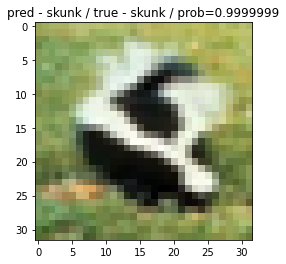

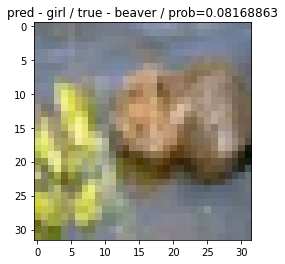

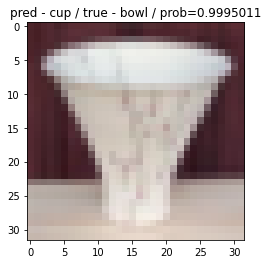

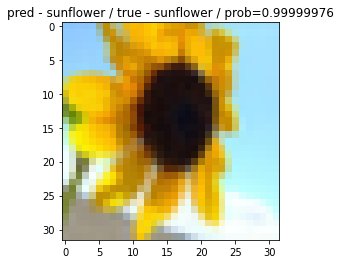

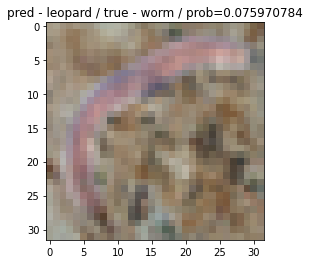

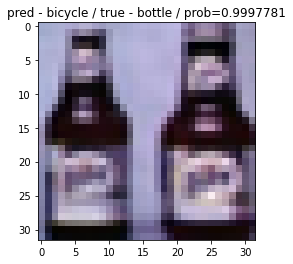

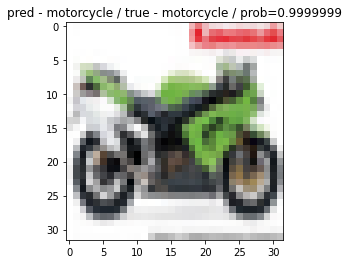

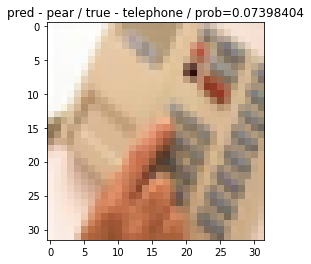

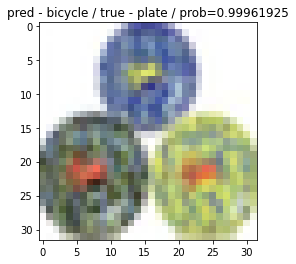

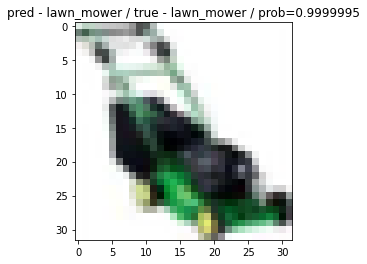

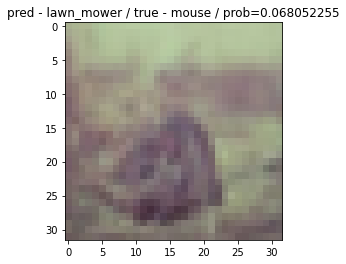

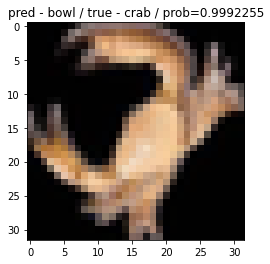

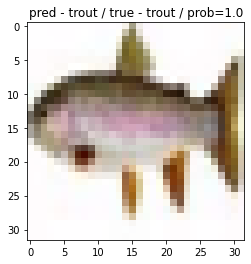

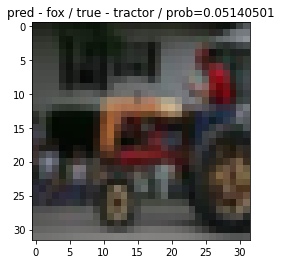

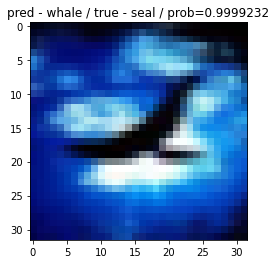

In [ ]:
model_gen = lambda: keras.Sequential(
    [
      keras.Input((32,32,3)),
      layers.Conv2D(32, 3, activation='relu'),
      layers.MaxPool2D(),
      layers.Conv2D(32, 3, activation='relu'),
      layers.AveragePooling2D(),
      layers.Flatten(),
      layers.Dense(100, activation='softmax')
    ]
)

evaluate(model_gen, "custom_model", "shallow_cnn", "no-aug", train_data, train_fine_labels, ita=False)

as we can see the performance is not very good, as expected from such a simplistic model, but we still can try to add some augmentation to find out if it can improve our performance even a little.

In [ ]:
evaluate(model_gen, "custom_model", "shallow_cnn-inplace", aug_inplace(images=train_data), train_fine_labels)

We can see that the results of the inplace augmentation are almost identical to that of the not augmented data, Thus we conclude that such augmentation will not help in this dataset, and we will not attempt to use it in the future.

In [ ]:
aug_train_data, aug_train_fine_labels = aug_add(train_data, train_fine_labels)
evaluate(model_gen, "custom_model", "shallow_cnn-add", aug_train_data, aug_train_fine_labels)

Here we see a very encouraging picture, the improvment is easliy seen in the graphs, and jumping from 35% to 42% on the test set is very good.

From the no augment run we can see a big diffrence between the validation/test accuracy and train accuracy, this suggests overfitting. It seems that adding the new data in the add augmentation has improved the situation though there still exists a difference. In our second iteration of the model 

In [ ]:
model_gen = lambda: keras.Sequential(
    [
      keras.Input((32,32,3)),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.Conv2D(128, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.1),
      layers.MaxPool2D(),
      layers.Conv2D(32, 1, activation='relu'),
      layers.Conv2D(128, 3, activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPool2D(),
      layers.Conv2D(128, 3, activation='relu'),
      layers.BatchNormalization(),
      layers.AveragePooling2D(),
      layers.Flatten(),
      layers.Dropout(0.25),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(100, activation='softmax')
    ]
)

# evaluate(model_gen, "custom_model", "deep_cnn-no-aug", train_data, train_fine_labels)

In [ ]:
aug_train_data, aug_train_fine_labels = aug_add(train_data, train_fine_labels)
# evaluate(model_gen, "custom_model", "deep_cnn-add", aug_train_data, aug_train_fine_labels)

In [ ]:
evaluate(model_gen, "custom_model", "deep_cnn-add-itu", aug_train_data, aug_train_fine_labels, ita=True)

wandb: Currently logged in as: zshoham (use `wandb login --relogin` to force relogin)


1512/1512 - 37s - loss: 3.5298 - accuracy: 0.1701 - val_loss: 3.0200 - val_accuracy: 0.2473
finished fitting
collected the garbege
